In [1]:
%load_ext autoreload
%autoreload 2
import machine_common_sense as mcs
from jax import numpy as jnp
from jax.random import split, PRNGKey
import random
import jax
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os

In [2]:
controller = mcs.create_controller("sample_config.ini")

Found path: /home/aldo/.mcs/0.6.1/MCS-AI2-THOR-Unity-App-v0.6.1.x86_64


In [7]:
scene_data = mcs.load_scene_json_file(f'./spatial_elimination_eval_5_ex_2.json')
ball_id = scene_data['goal']['metadata']['target']['id']
ball_id

'target'

In [8]:
output = controller.start_scene(scene_data)

In [10]:
%%timeit
for _ in range(20):
    s = controller.step('RotateRight')

3.82 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


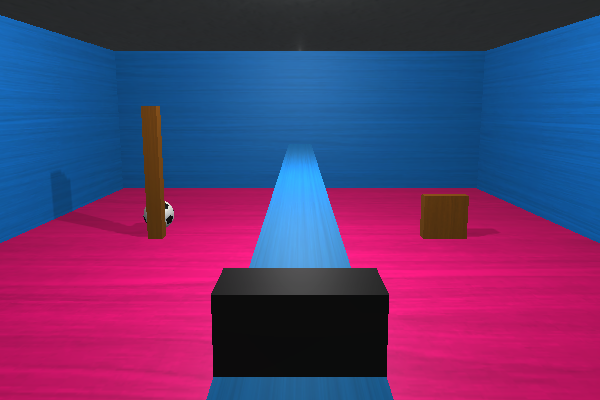

In [9]:
output.image_list[-1]


In [7]:
b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
ball_mask_rgb = ball_color
mask = jnp.asarray(s.object_mask_list[-1])

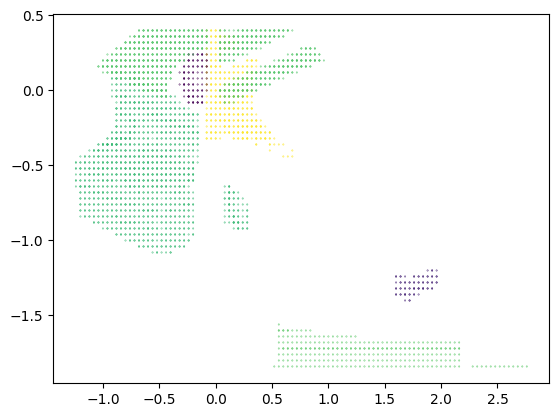

In [8]:
def get_camera_intrinsics(aspect_ratio, field_of_view):
    width, height = aspect_ratio
    aspect_ratio = width / height
    
    cx, cy = width / 2.0, height / 2.0
    
    fov_y = jnp.deg2rad(field_of_view)

    fov_x = 2 * jnp.arctan(aspect_ratio * jnp.tan(fov_y/2.0))
    
    fx = cx / jnp.tan(fov_x / 2.0)
    fy = cy / jnp.tan(fov_y / 2.0)
    
    return cx, cy, fx, fy

def depth_image_to_point_cloud(depth, cx,cy,fx,fy):
    height, width = depth.shape
    xs = (depth * (jnp.arange(width) - cx - 0.5).reshape(1,-1) / fx).reshape(-1)
    ys = (depth * (jnp.arange(height) - cy - 0.5).reshape(-1,1) / fy).reshape(-1)
    zs = depth.reshape(-1)
    
    point_cloud = jnp.stack([xs,ys,zs],axis=0)
    
    return point_cloud
    
def mask_rgb_to_id(mask_rgb):
    r,g,b = mask_rgb
    return jnp.uint32(r+1) + jnp.uint32(g+1) * 256 + jnp.uint32(b+1)*256**2

def get_id_from_masks(ball_color,mask_rgb):
    return jax.lax.cond(jnp.alltrue(ball_color==mask_rgb),lambda: jnp.uint32(0), lambda: mask_rgb_to_id(mask_rgb))

@jax.jit
def make_rgb_point_cloud_ball(ball_mask_rgb:jnp.ndarray, mask:jnp.ndarray, rgb:jnp.ndarray, depth:jnp.ndarray, aspect_ratio, field_of_view, voxel_res = None):
    """computes a flat point cloud (3xN where N is the number of pixels) given a depth map. Also returns the ids, where the ball is always 0 and all others are
    a random integer. It also returns a corresponding RGB cloud.
    """
    cx, cy, fx, fy = get_camera_intrinsics(aspect_ratio,field_of_view)
    depth_cloud = depth_image_to_point_cloud(depth, cx, cy, fx, fy)
    rgb_cloud = jnp.stack([rgb[:,:,i].reshape(-1) for i in range(3)],axis=0)
    
    ids = jax.vmap(jax.vmap(get_id_from_masks, in_axes=(None,0)),in_axes=(None,0))(ball_mask_rgb, mask).reshape(-1)
    
    if voxel_res is not None:
        depth_cloud = jnp.round(depth_cloud/voxel_res)*voxel_res
    
    return depth_cloud, rgb_cloud, ids

def filter_unique_depths(depth_cloud, rgb_cloud, all_masks):
    _,idxs = jnp.unique(depth_cloud, axis=1, return_index=True)
    return depth_cloud[:,idxs], rgb_cloud[:,idxs], all_masks[idxs]

d, r, i = jax.jit(make_rgb_point_cloud_ball)(ball_color, mask, jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view, 0.04)
# ball_mask = jax.vmap(jax.vmap(compare_pixels, in_axes=(None,0)),in_axes=(None,0))(ball_mask_rgb, mask)
# plt.imshow(s.object_mask_list[-1])
# plt.scatter(d[0],d[1],c=i,s=0.01)

b_d, b_r, b_i = filter_unique_depths(d,r,i)
plt.scatter(b_d[0],b_d[1],c=b_i,s=0.1)
plt.show()

In [64]:
def load_scene(i):
    scene_data = mcs.load_scene_json_file(f'./ball_scenes/_{i+1:06}.json')
    ball_id = scene_data['goal']['metadata']['target']['id']
    s = controller.start_scene(scene_data)
    b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
    ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
    return ball_color, s

@jax.jit
def soccer_ball_in_ids(ids):
    return jax.lax.cond(jnp.any(ids == 0), lambda: True, lambda: False)

@jax.jit
def get_ball_centroid(depth, ids):
    pc_sum = jnp.where(ids==0, depth[3], 0).sum()
    mask_size = (ids == 0).sum()
    return pc_sum/mask_size

def add_random_camera_jitter(key):
    '''adds random rotations to the camera
    '''
    INV_MOVES = {'LookUp':'LookDown', 'LookDown':'LookUp', 'RotateLeft':'RotateRight', 'RotateRight':'RotateLeft'}
    vertical_move = random.choice(['LookUp','LookDown'])
    horizontal_move = random.choice(['RotateLeft', 'RotateRight'])
    num_steps = jax.random.randint(key, (1,), minval=0, maxval=3).item()
    for _ in range(num_steps):
        move = random.choice([vertical_move,horizontal_move])
        s = controller.step(move)
        d,r,ids = make_rgb_point_cloud_ball(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view, voxel_res=0.04)
        if not soccer_ball_in_ids(ids):
            move = INV_MOVES[move]
            s = controller.step(move)
            d,r,ids = make_rgb_point_cloud_ball(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view, voxel_res=0.04)
            assert soccer_ball_in_ids(ids)    
            print('hit view border')
            break
    return d,r,ids

MAX_SIZE = 2000

@jax.jit
def make_centered_padded_data(d_masked,r_masked):
    size = d_masked.shape[1]
    d_centered = d_masked - d_masked.mean(axis=1)[:,None]
    
    data_mask = jnp.zeros((MAX_SIZE,),dtype=jnp.uint8)
    data_mask = data_mask.at[0:size].set(True)
    
    data_depth = jnp.zeros((3,MAX_SIZE,))
    data_depth = data_depth.at[:,0:size].set(d_centered)
    
    data_rgb = jnp.zeros((3,MAX_SIZE,),dtype=jnp.uint8)
    data_rgb = data_depth.at[:,0:size].set(r_masked)
    return data_depth, data_rgb, data_mask
    
    
def create_datasets(h5py_file):
    f = h5py_file
    masks = f.create_dataset('masks', (10**1,MAX_SIZE), maxshape=(None,MAX_SIZE),
                        dtype='i1', chunks=(10**2,MAX_SIZE))
    rgb_clouds = f.create_dataset('rgb_clouds', (10**1,3,MAX_SIZE), maxshape=(None,3,MAX_SIZE),
                        dtype='i1', chunks=(10**2,3,MAX_SIZE))
    depth_clouds = f.create_dataset('depth_clouds', (10**1,3,MAX_SIZE), maxshape=(None,3,MAX_SIZE),
                        dtype='i4', chunks=(10**2,3,MAX_SIZE))
    labels = f.create_dataset('labels', (10**1,), maxshape=(None,),
                        dtype='i1', chunks=(10**2,))
    return masks, rgb_clouds, depth_clouds, labels

def resize_databases(h5py_file, num_extra):
    map(lambda x: x.rezise(x.shape[0] + num_extra, axis=0), [depth_db, rgb_db, m_db, labels_db])

def save_data(depth, rgb, mask, label, save_i):
    if save_i > depth_db.shape[0]:
        resize_databases()
        
    map(lambda db,val: db.__setitem__(save_i,val), zip([depth_db,rgb_db,m_db,labels_db],
                                                       [depth, rgb, mask, label]))
    
    save_i += 1
    return save_i
                                            

In [49]:
mask = b_i == 0
v_d = b_d[:,mask]
v_r = b_r[:,mask]
d, r, m = make_centered_padded_data(v_d, v_r)
m.shape

(2000,)

In [63]:
import os
data_path = "./soccer_balls_data.h5"
os.remove(data_path)

k = PRNGKey(156)
with h5py.File(data_path, "a") as f:
    masks, rgb_clouds, depth_clouds, labels = create_datasets(f)
    masks[0] = m
    rgb_clouds[0] = r
    depth_clouds[0] = d
    label = True
    labels[0] = label

    print(masks[0].shape)
    print(rgb_clouds.shape)
    print(depth_clouds.shape)
    print(labels[:])
    masks.__setitem__(0,m)
    print(masks[0])

(2000,)
(10, 3, 2000)
(10, 3, 2000)
[1 0 0 0 0 0 0 0 0 0]
[1 1 1 ... 0 0 0]


In [11]:
import os
import h5py
import numpy as np

data_path = "./soccer_balls_data.h5"
os.remove(data_path)

k = PRNGKey(156)
with h5py.File(path, "a") as f:
    m_db, rgb_db, depth_db, labels_db = create_datasets(f)
    save_i = 0
    for i in range(999999):
        ball_color, s = load_scene(i)
        d, r, ids = make_rgb_point_cloud_ball(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view, voxel_res=0.04)
        if not soccer_ball_in_ids(ids):
            print('scene_no_ball', i)
            continue

        k, sk = split(k)
        d,r,ids = add_random_camera_jitter(sk)

        v_d, v_r, v_m = filter_unique_depths(d,r,ids)
        for id in jnp.unique(v_m):
            mask = v_m == id
            size = mask.sum()
            if size>MAX_SIZE:
                continue
            
            o_d, o_r = v_d[:,mask], v_r[:,mask]
            
            p_d, p_r, p_m = make_centered_padded_data(o_d, o_r)
            label = True if id == 0 else False
            
            save_i = save_data(p_d, p_r, p_m, label, save_i)

0
num_steps 5
centroid 1.3652496
1
num_steps 4
centroid 11.55077
2
scene_no_ball 2
3
num_steps 6
centroid 8.617458
4
scene_no_ball 4
5
scene_no_ball 5
6
num_steps 3
centroid 6.185542
7
num_steps 5
centroid 7.5480905
8
num_steps 5
centroid 17.446516
9
num_steps 5
centroid 14.0493145
10
num_steps 3
centroid 2.7727566
11
num_steps 5
centroid 24.971724
12
scene_no_ball 12
13
scene_no_ball 13
14
scene_no_ball 14
15
num_steps 3
centroid 5.3687077
16
num_steps 5
centroid 4.1495876
17
num_steps 4
centroid 21.163929
18
num_steps 3
centroid 3.8804955
19
num_steps 10
centroid 0.59733826
20
num_steps 4
centroid 9.473568
21
num_steps 4
centroid 5.827443
22
scene_no_ball 22
23
num_steps 3
centroid 7.7708545
24
num_steps 5
centroid 8.894857
25
num_steps 5
centroid 6.2537074
26
scene_no_ball 26
27
num_steps 5
centroid 13.432315
28
scene_no_ball 28
29
scene_no_ball 29
30
scene_no_ball 30
31
num_steps 4
centroid 3.4560483
32
num_steps 5
centroid 9.937143
33
num_steps 5
centroid 10.321538
34
scene_no_bal

KeyboardInterrupt: 

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/aldo/miniconda3/envs/mcs/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/aldo/miniconda3/envs/mcs/lib/python3.8/threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "/home/aldo/miniconda3/envs/mcs/lib/python3.8/site-packages/machine_common_sense/controller.py", line 171, in _check_step_for_timeout
    self.end_scene(rating=None, score=-1)
  File "/home/aldo/miniconda3/envs/mcs/lib/python3.8/site-packages/typeguard/__init__.py", line 1033, in wrapper
    retval = func(*args, **kwargs)
  File "/home/aldo/miniconda3/envs/mcs/lib/python3.8/site-packages/machine_common_sense/controller.py", line 499, in end_scene
    raise RuntimeError("end_scene called twice with the same scene")
RuntimeError: end_scene called twice with the same scene
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/aldo/miniconda3/envs/mcs/l

5


(3, 157)

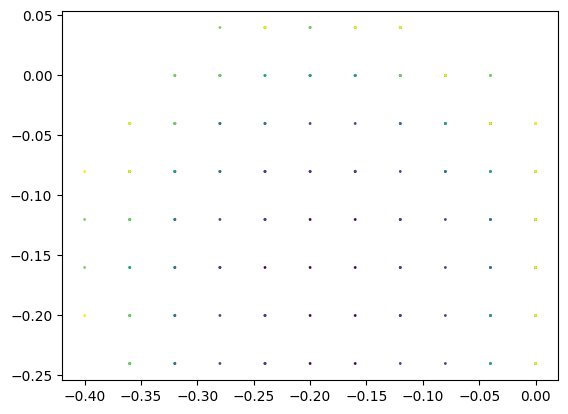

In [16]:
i=5
print(i)
scene_data = mcs.load_scene_json_file(f'./ball_scenes/_{i+1:06}.json')
ball_id = scene_data['goal']['metadata']['target']['id']
s = controller.start_scene(scene_data)
b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
d, r, i_ = jax.jit(make_rgb_point_cloud_ball)(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view, v)
v_d, v_r, v_m = voxelize(d,r,i_,0.04)
for id in jnp.unique(v_m):
    idxs = v_m == id
    if idxs.sum()>MAX_SIZE:
        continue
    o_d, o_r = v_d[:,idxs], v_r[:,idxs]

    
idxs = v_m == 0
o_d, o_r = v_d[:,idxs], v_r[:,idxs]
plt.scatter(o_d[0],o_d[1],c=o_d[2],s=1)
o_d.shape

In [ ]:
_